<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 364, '日付': '2021-03-30T08:00:00.000Z'},
 {'小計': 414, '日付': '2021-03-31T08:00:00.000Z'},
 {'小計': 475, '日付': '2021-04-01T08:00:00.000Z'},
 {'小計': 440, '日付': '2021-04-02T08:00:00.000Z'},
 {'小計': 446, '日付': '2021-04-03T08:00:00.000Z'},
 {'小計': 355, '日付': '2021-04-04T08:00:00.000Z'},
 {'小計': 249, '日付': '2021-04-05T08:00:00.000Z'},
 {'小計': 399, '日付': '2021-04-06T08:00:00.000Z'},
 {'小計': 555, '日付': '2021-04-07T08:00:00.000Z'},
 {'小計': 545, '日付': '2021-04-08T08:00:00.000Z'},
 {'小計': 537, '日付': '2021-04-09T08:00:00.000Z'},
 {'小計': 570, '日付': '2021-04-10T08:00:00.000Z'},
 {'小計': 421, '日付': '2021-04-11T08:00:00.000Z'},
 {'小計': 306, '日付': '2021-04-12T08:00:00.000Z'},
 {'小計': 510, '日付': '2021-04-13T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-04-09 17:00:00+09:00,390,0,537,2021-04-09 17:00:00+09:00
2021-04-10 17:00:00+09:00,381,0,570,2021-04-10 17:00:00+09:00
2021-04-11 17:00:00+09:00,315,0,421,2021-04-11 17:00:00+09:00
2021-04-12 17:00:00+09:00,412,0,306,2021-04-12 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-04-09 17:00:00+09:00,390,0,537,2021-04-09 17:00:00+09:00,352.571429,2468.0,0.0,0.0,440.857143,3086.0
2021-04-10 17:00:00+09:00,381,0,570,2021-04-10 17:00:00+09:00,354.714286,2483.0,0.0,0.0,458.571429,3210.0
2021-04-11 17:00:00+09:00,315,0,421,2021-04-11 17:00:00+09:00,350.571429,2454.0,0.0,0.0,468.000000,3276.0
2021-04-12 17:00:00+09:00,412,0,306,2021-04-12 17:00:00+09:00,362.142857,2535.0,0.0,0.0,476.142857,3333.0
2021-04-13 17:00:00+09:00,0,0,510,2021-04-13 17:00:00+09:00,314.285714,2200.0,0.0,0.0,492.000000,3444.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-03-30 17:00:00+09:00,279,0,364,2021-03-30 17:00:00+09:00,277.000000,1939.0,0.0,0.0,361.571429,2531.0,'21w13,Tue
2021-03-31 17:00:00+09:00,326,0,414,2021-03-31 17:00:00+09:00,286.857143,2008.0,0.0,0.0,360.714286,2525.0,'21w13,Wed
2021-04-01 17:00:00+09:00,304,0,475,2021-04-01 17:00:00+09:00,293.428571,2054.0,0.0,0.0,372.285714,2606.0,'21w13,Thu
2021-04-02 17:00:00+09:00,336,0,440,2021-04-02 17:00:00+09:00,304.428571,2131.0,0.0,0.0,381.428571,2670.0,'21w13,Fri
2021-04-03 17:00:00+09:00,366,0,446,2021-04-03 17:00:00+09:00,312.714286,2189.0,0.0,0.0,383.714286,2686.0,'21w13,Sat
2021-04-04 17:00:00+09:00,344,0,355,2021-04-04 17:00:00+09:00,323.428571,2264.0,0.0,0.0,389.714286,2728.0,'21w13,Sun
2021-04-05 17:00:00+09:00,331,0,249,2021-04-05 17:00:00+09:00,326.571429,2286.0,0.0,0.0,391.857143,2743.0,'21w14,Mon
2021-04-06 17:00:00+09:00,335,0,399,2021-04-06 17:00:00+09:00,334.571429,2342.0,0.0,0.0,396.857143,2778.0,'21w14,Tue
2021-04-07 17:00:00+09:00,326,0,555,2021-04-07 17:00:00+09:00,334.571429,2342.0,0.0,0.0,417.000000,2919.0,'21w14,Wed
2021-04-08 17:00:00+09:00,376,0,545,2021-04-08 17:00:00+09:00,344.857143,2414.0,0.0,0.0,427.000000,2989.0,'21w14,Thu


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-03-28 17:00:00+09:00,351.000000,2457
2021-04-04 17:00:00+09:00,389.714286,2728
2021-04-11 17:00:00+09:00,468.000000,3276
2021-04-13 17:00:00+09:00,408.000000,816
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-03-30 17:00:00+09:00,279,0,364,2021-03-30 17:00:00+09:00,277.000000,1939.0,0.0,0.0,361.571429,2531.0,'21w13,Tue,NaN,NaN
2021-03-31 17:00:00+09:00,326,0,414,2021-03-31 17:00:00+09:00,286.857143,2008.0,0.0,0.0,360.714286,2525.0,'21w13,Wed,NaN,NaN
2021-04-01 17:00:00+09:00,304,0,475,2021-04-01 17:00:00+09:00,293.428571,2054.0,0.0,0.0,372.285714,2606.0,'21w13,Thu,NaN,NaN
2021-04-02 17:00:00+09:00,336,0,440,2021-04-02 17:00:00+09:00,304.428571,2131.0,0.0,0.0,381.428571,2670.0,'21w13,Fri,NaN,NaN
2021-04-03 17:00:00+09:00,366,0,446,2021-04-03 17:00:00+09:00,312.714286,2189.0,0.0,0.0,383.714286,2686.0,'21w13,Sat,NaN,NaN
2021-04-04 17:00:00+09:00,344,0,355,2021-04-04 17:00:00+09:00,323.428571,2264.0,0.0,0.0,389.714286,2728.0,'21w13,Sun,389.714286,2728.0
2021-04-05 17:00:00+09:00,331,0,249,2021-04-05 17:00:00+09:00,326.571429,2286.0,0.0,0.0,391.857143,2743.0,'21w14,Mon,NaN,NaN
2021-04-06 17:00:00+09:00,335,0,399,2021-04-06 17:00:00+09:00,334.571429,2342.0,0.0,0.0,396.857143,2778.0,'21w14,Tue,NaN,NaN
2021-04-07 17:00:00+09:00,326,0,555,2021-04-07 17:00:00+09:00,334.571429,2342.0,0.0,0.0,417.000000,2919.0,'21w14,Wed,NaN,NaN
2021-04-08 17:00:00+09:00,376,0,545,2021-04-08 17:00:00+09:00,344.857143,2414.0,0.0,0.0,427.000000,2989.0,'21w14,Thu,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

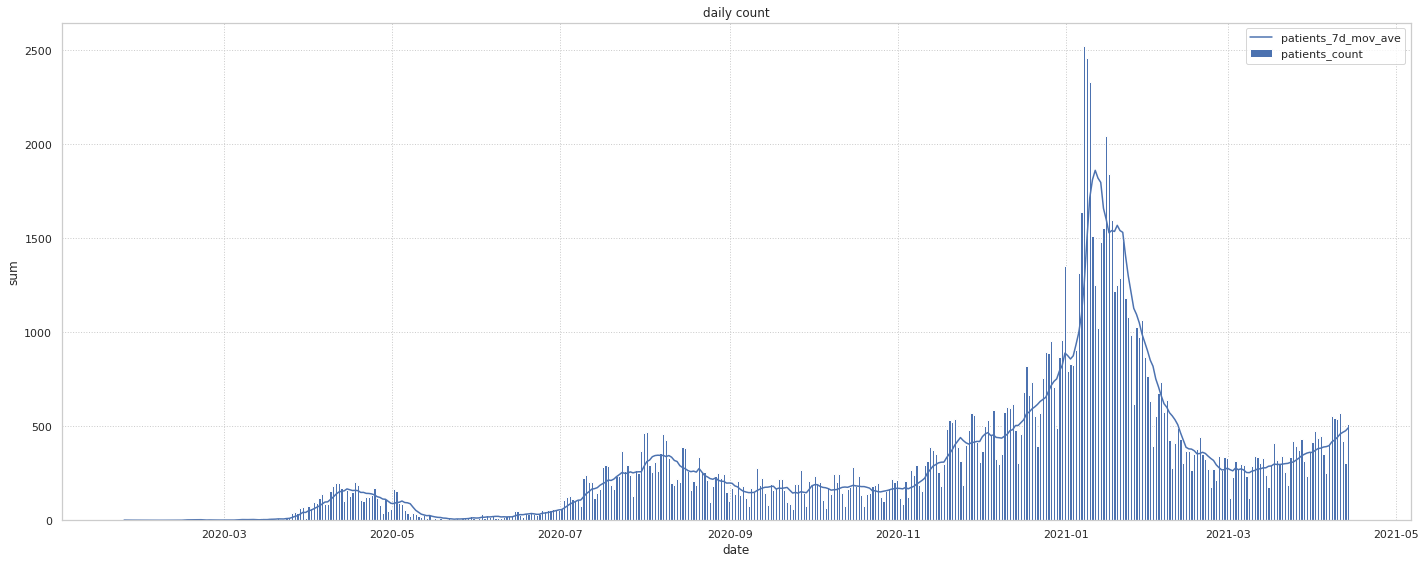

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
431,1.617091e+09,2021,3,30,0,0,0,0,0,1,0,431,0,357,279,277.000000,1939.0,0,0.0,0.0,364,361.571429,2531.0
432,1.617178e+09,2021,3,31,0,0,0,0,0,0,1,432,0,358,326,286.857143,2008.0,0,0.0,0.0,414,360.714286,2525.0
433,1.617264e+09,2021,4,1,0,0,0,0,1,0,0,433,0,359,304,293.428571,2054.0,0,0.0,0.0,475,372.285714,2606.0
434,1.617350e+09,2021,4,2,1,0,0,0,0,0,0,434,0,360,336,304.428571,2131.0,0,0.0,0.0,440,381.428571,2670.0
435,1.617437e+09,2021,4,3,0,0,1,0,0,0,0,435,0,361,366,312.714286,2189.0,0,0.0,0.0,446,383.714286,2686.0
436,1.617523e+09,2021,4,4,0,0,0,1,0,0,0,436,0,362,344,323.428571,2264.0,0,0.0,0.0,355,389.714286,2728.0
437,1.617610e+09,2021,4,5,0,1,0,0,0,0,0,437,0,363,331,326.571429,2286.0,0,0.0,0.0,249,391.857143,2743.0
438,1.617696e+09,2021,4,6,0,0,0,0,0,1,0,438,0,364,335,334.571429,2342.0,0,0.0,0.0,399,396.857143,2778.0
439,1.617782e+09,2021,4,7,0,0,0,0,0,0,1,439,0,365,326,334.571429,2342.0,0,0.0,0.0,555,417.000000,2919.0
440,1.617869e+09,2021,4,8,0,0,0,0,1,0,0,440,0,366,376,344.857143,2414.0,0,0.0,0.0,545,427.000000,2989.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446 entries, 0 to 445
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            446 non-null    float64
 1   year                 446 non-null    int64  
 2   month                446 non-null    int64  
 3   day                  446 non-null    int64  
 4   Fri                  446 non-null    uint8  
 5   Mon                  446 non-null    uint8  
 6   Sat                  446 non-null    uint8  
 7   Sun                  446 non-null    uint8  
 8   Thu                  446 non-null    uint8  
 9   Tue                  446 non-null    uint8  
 10  Wed                  446 non-null    uint8  
 11  passed               446 non-null    int64  
 12  emergency            446 non-null    int64  
 13  em_passed            446 non-null    int64  
 14  contacts_count       446 non-null    int64  
 15  contacts_7d_mov_ave  446 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,4.460000e+02,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.00000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000
mean,1.599077e+09,2020.230942,5.813901,15.650224,0.143498,0.143498,0.143498,0.143498,0.141256,0.143498,0.141256,222.500000,0.109865,154.721973,683.43722,681.638640,4771.461883,826.275785,826.275785,5783.930493,284.291480,281.220788,1968.508969
std,1.113639e+07,0.421908,3.489810,8.879902,0.350973,0.350973,0.350973,0.350973,0.348676,0.350973,0.348676,128.893367,0.313073,120.053748,457.48278,444.660044,3112.633444,880.609923,780.426943,5462.988602,364.322422,344.929121,2414.533653
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.589465e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,111.250000,0.000000,37.250000,375.25000,375.214286,2626.500000,0.000000,0.000000,0.000000,42.250000,41.535714,290.750000
50%,1.599077e+09,2020.000000,5.000000,15.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,222.500000,0.000000,148.500000,541.50000,557.714286,3904.000000,646.500000,925.142857,6476.000000,187.500000,176.642857,1236.500000
75%,1.608689e+09,2020.000000,9.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,333.750000,0.000000,259.750000,824.00000,847.714286,5934.000000,1442.250000,1413.178571,9892.250000,353.750000,345.892857,2421.250000
max,1.618301e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,445.000000,1.000000,371.000000,2265.00000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,2520.000000,1861.142857,13028.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.729949,0.154778,-0.022977,-0.006358,0.003179,-0.003179,-2.141813e-18,0.001575,0.006358,-0.001575,1.000000e+00,-0.339726,0.993771,-0.279292,-0.258573,-0.258568,-0.461873,-0.496465,-0.496465,0.581913,0.618222,0.618240
year,7.299490e-01,1.000000,-0.559870,-0.073760,0.003335,0.003335,0.003335,3.334562e-03,-0.008391,0.003335,-0.008391,7.299490e-01,-0.192519,0.755263,-0.263366,-0.234997,-0.234995,-0.514755,-0.580834,-0.580834,0.543849,0.602780,0.602780
month,1.547783e-01,-0.559870,1.000000,-0.004426,-0.013007,-0.000165,-0.009338,-5.668633e-03,0.014265,0.003505,0.010571,1.547783e-01,-0.131391,0.110266,0.044905,0.028702,0.028706,0.186568,0.241862,0.241862,-0.083879,-0.126555,-0.126533
day,-2.297727e-02,-0.073760,-0.004426,1.000000,0.005325,-0.009095,0.006767,9.651550e-03,-0.002151,-0.006932,-0.003603,-2.297727e-02,0.001729,-0.022315,-0.004565,-0.002973,-0.002977,0.019368,0.004316,0.004316,-0.015605,-0.004088,-0.004104
Fri,-6.358361e-03,0.003335,-0.013007,0.005325,1.000000,-0.167539,-0.167539,-1.675393e-01,-0.166008,-0.167539,-0.166008,-6.358361e-03,-0.000642,-0.005184,-0.018264,-0.003433,-0.003432,0.037956,-0.001937,-0.001937,0.048670,-0.002636,-0.002645
Mon,3.179180e-03,0.003335,-0.000165,-0.009095,-0.167539,1.000000,-0.167539,-1.675393e-01,-0.166008,-0.167539,-0.166008,3.179180e-03,-0.000642,0.003296,0.039678,-0.001154,-0.001153,0.155147,-0.001937,-0.001937,-0.114825,0.000792,0.000794
Sat,-3.179180e-03,0.003335,-0.009338,0.006767,-0.167539,-0.167539,1.000000,-1.675393e-01,-0.166008,-0.167539,-0.166008,-3.179180e-03,-0.000642,-0.002358,0.046102,-0.002650,-0.002649,-0.182785,-0.001937,-0.001937,0.055752,-0.001127,-0.001134
Sun,-2.141813e-18,0.003335,-0.005669,0.009652,-0.167539,-0.167539,-0.167539,1.000000e+00,-0.166008,-0.167539,-0.166008,-1.411840e-18,-0.000642,0.000469,-0.016920,-0.002002,-0.002001,-0.168542,-0.001937,-0.001937,-0.035687,-0.000017,-0.000017
Thu,1.575062e-03,-0.008391,0.014265,-0.002151,-0.166008,-0.166008,-0.166008,-1.660081e-01,1.000000,-0.166008,-0.164491,1.575062e-03,0.001615,0.000242,-0.007037,0.005616,0.005617,0.050387,0.004874,0.004874,0.076574,0.001152,0.001158
Tue,6.358361e-03,0.003335,0.003505,-0.006932,-0.167539,-0.167539,-0.167539,-1.675393e-01,-0.166008,1.000000,-0.166008,6.358361e-03,-0.000642,0.006122,-0.031042,-0.001154,-0.001153,0.060866,-0.001937,-0.001937,-0.034826,0.002142,0.002146


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,1.617955e+09,1,0,0,0,0,0,0,441,0,367,390,0,537,440.857143,3086.0
442,1.618042e+09,0,0,1,0,0,0,0,442,0,368,381,0,570,458.571429,3210.0
443,1.618128e+09,0,0,0,1,0,0,0,443,0,369,315,0,421,468.000000,3276.0
444,1.618214e+09,0,1,0,0,0,0,0,444,0,370,412,0,306,476.142857,3333.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
441,1.617955e+09,441,0,537,440.857143,3086.0
442,1.618042e+09,442,0,570,458.571429,3210.0
443,1.618128e+09,443,0,421,468.000000,3276.0
444,1.618214e+09,444,0,306,476.142857,3333.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

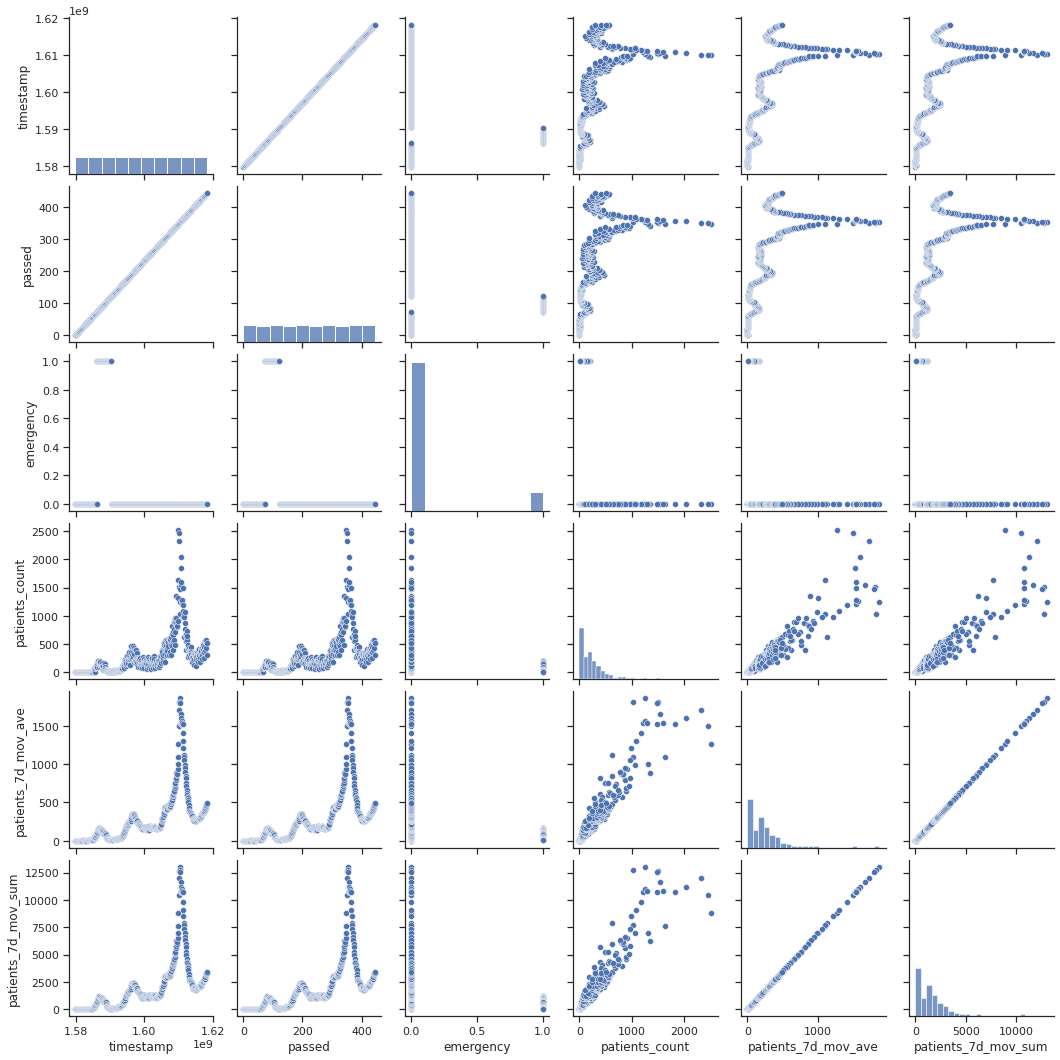

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.10
